# Summary

- Exploratory Data Analysis + Data Visualization
- Data preprocessing
    - Impute Missings [train + test]
    - Remove Outliers [train] ==> defer to Feature Engineering
- Feature Engineering
    - Transform Mis-typed Numerical to Categorical features [train + test]
    - Add combinations of Numerical features [train + test]
    - Transform Categorical to Numerical features (with ordering, labelencoder) [train + test]
    - Add further combinational features of Numerical features [train + test]
    - Transform Categorical to Numerical features (without ordering, one-hot encoding) [train + test]
    - Split into transformed train and test datasets
    - UnSkew features [train, then test]
    - Feature Scaling [train, then test]
    - Remove Outliers [train]
- Modelling
    


### Cheatsheet of Seaborn:
- numerical:
    - univariate distributions -> sns.distplot
    - Bivariate distributions -> plt.scatter
    - Pairwise relationsips -> sns.pairplot

- categorical:
    - scatterplots -> sns.stripplot / sns.swarmplot
    - distributions within categories -> sns.boxplot
    - statistical estimation within categories -> sns.barplot
    - historgram-like -> sns.countplot 

# Import modules, libraries

In [1]:
import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew, lognorm

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost


KFOLD = 5
RANDOM_SEED = 0


/home/winston/.pyenv/versions/3.5.2/envs/tf-p35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load datasets

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

# use total_df for data cleaning & feature engineering later on
total_df = pd.concat([train_df, test_df], ignore_index=True)

# Preview datasets

In [3]:
print('Training dataset columns & shapes:')
print(train_df.columns.values, train_df.shape)
print('-'*80)
print('Test dataset columns & shapes:')
print(test_df.columns.values, test_df.shape)
print('-'*80)
print('Peek train dataset')
train_df.head()

Training dataset columns & shapes:
['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## (1) Check features datatypes

In [4]:
num_features = [col for col in total_df.columns if total_df.dtypes[col] != 'object']
cat_features = [col for col in total_df.columns if total_df.dtypes[col] == 'object']
print('numeric features # = %d & categorical features # = %d' % (len(num_features), len(cat_features)))

numeric features # = 38 & categorical features # = 43


## (2) Check missing values

In [5]:
# Peak missing values

def get_missing_cols(dataframe):
    cols_with_missing_value = dataframe.columns[dataframe.isnull().any()].tolist()
    return cols_with_missing_value

missing_count = total_df[get_missing_cols(total_df)].isnull().sum()
missing_ratio = missing_count / len(total_df) * 100
missing_count = missing_count.sort_values(ascending=False)
missing_ratio = missing_ratio.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing count': missing_count, 'Missing ratio': missing_ratio})
missing_data

,Missing count,Missing ratio
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
SalePrice,1459,49.982871
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageQual,159,5.447071
GarageCond,159,5.447071
GarageFinish,159,5.447071


## (3) Checking data skewness

In [6]:
skewed_features = abs(total_df.skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_features[skewed_features.values > 0.75]})
print("There are {} skewed numerical features to transform later".format(skewness.shape[0]))
skewness


There are 23 skewed numerical features to transform later


,Skew
MiscVal,21.958480
PoolArea,16.907017
LotArea,12.829025
LowQualFinSF,12.094977
3SsnPorch,11.381914
KitchenAbvGr,4.304467
BsmtFinSF2,4.147456
EnclosedPorch,4.005950
ScreenPorch,3.948723
BsmtHalfBath,3.932018


## (4) Checking outliers

In [7]:
# Check outliers w.r.t. SalePrice 
import statsmodels.api as sm

num_cols = [col for col in train_df.columns if train_df.dtypes[col] != 'object']
X = train_df[num_cols].dropna()
y = X['SalePrice']
X = X.drop(['SalePrice','Id'], axis=1)

model = sm.OLS(y, X)
results = model.fit()
bonf_test = results.outlier_test()['bonf(p)']
bonf_outlier = list(bonf_test[bonf_test<1e-3].index) 
print(bonf_outlier)

[523, 691, 803, 898, 1046, 1182, 1298]


- There are 7 outliers, let's check again and remove them after feature engineering 

## (5) Check target variables

skew:  1.880940746034036


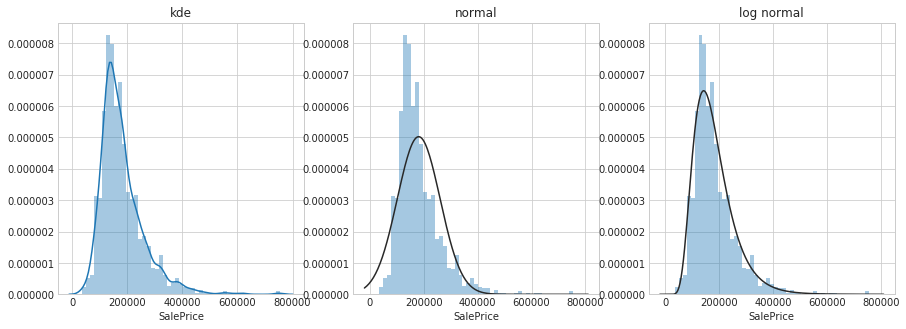

In [8]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15,5))
axis1.set_title('kde')
sns.distplot(train_df['SalePrice'], kde=True, ax=axis1)
axis2.set_title('normal')
sns.distplot(train_df['SalePrice'], kde=False, fit=norm, ax=axis2)
axis3.set_title('log normal')
sns.distplot(train_df['SalePrice'], kde=False, fit=lognorm, ax=axis3)

print('skew: ', skew(train_df['SalePrice']))


- SalePrice is not normal distributed, perform log transformation might fix this.

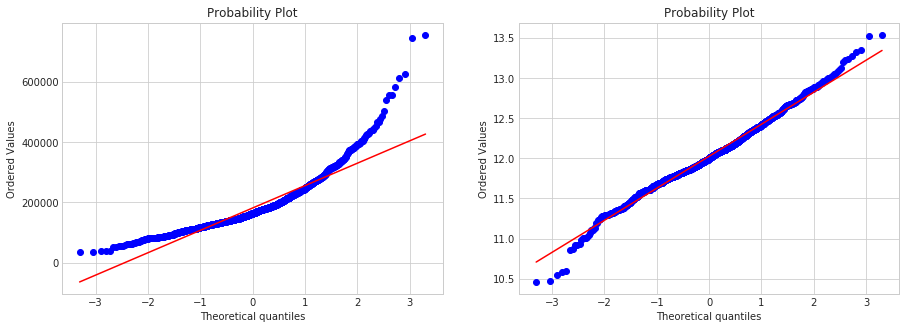

In [9]:
# Preview normal probability plots of original & log transformed target variable
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,5))
axis1.set_title('original')
res = stats.probplot(train_df['SalePrice'], plot=axis1)
axis2.set_title('log transformation')
res = stats.probplot(np.log1p(train_df['SalePrice']), plot=axis2)


In [10]:
def is_normal_dist(X):
    return not (stats.normaltest(X)[1] < 0.05) # traditionally, in statistics, p-value < 0.05 to reject null hypothesis

is_normal_dist(train_df['SalePrice'])

False

# Data correlation analysis

## (1) Numeric Features 

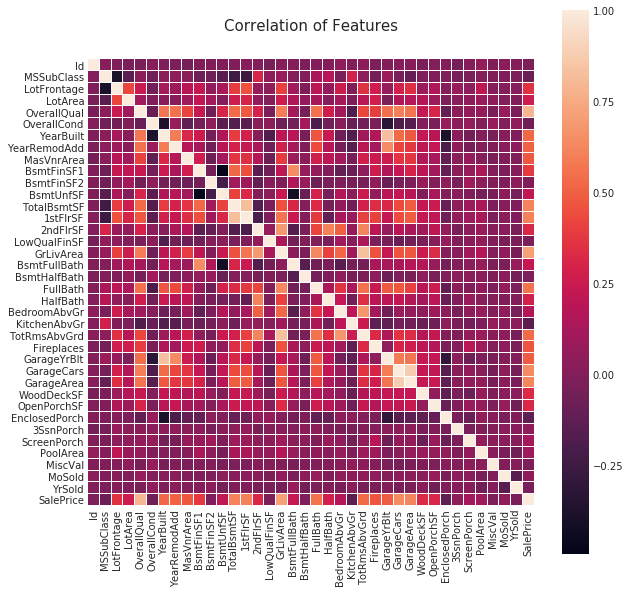

In [11]:
# Check correlations among numeric variables

plt.figure(figsize=(10,10))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white')

In [12]:
# check correlation matrix with SalePrice (positive & negative)
abs(train_df.drop(['Id'], axis=1).corr()['SalePrice']).sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

### Observations:
#### correlated numeric features:
- Highly correlated: TotalBsmtSF / 1stFlrSF & GarageArea / GarageCars
- SalePrice correlated: OverallQual, GrLivArea, GarageX 




# Data Preprocessing

## Impute missing values

### (1) filling values per data description

In [13]:
def has_null(dataframe, col):
    return dataframe[col].isnull().any()

total_df['PoolQC'].fillna('NA', inplace=True) # NA for no pool 
total_df['MiscFeature'].fillna('NA', inplace=True) # NA for no misc feature
total_df['Alley'].fillna('NA', inplace=True) # NA for no alley access
total_df['Fence'].fillna('NA', inplace=True) # NA for no fence
total_df['FireplaceQu'].fillna('NA', inplace=True) # NA for no fireplace
total_df['GarageQual'].fillna('NA', inplace=True) # NA for no garage
total_df['GarageCond'].fillna('NA', inplace=True) # NA for no garage
total_df['GarageFinish'].fillna('NA', inplace=True) # NA for no garage
total_df['GarageType'].fillna('NA', inplace=True) # NA for no garage
total_df['BsmtExposure'].fillna('NA', inplace=True) # NA for no basement
total_df['BsmtCond'].fillna('NA', inplace=True) # NA for no basement
total_df['BsmtQual'].fillna('NA', inplace=True) # NA for no basement
total_df['BsmtFinType2'].fillna('NA', inplace=True) # NA for no basement
total_df['BsmtFinType1'].fillna('NA', inplace=True) # NA for no basement
total_df['MasVnrType'].fillna('NA', inplace=True) # NA for no masonry veneer
total_df['MasVnrArea'].fillna(0, inplace=True) # 0 for no masonry veneer

total_df['BsmtFullBath'].fillna(0, inplace=True) # 0 for no basement
total_df['BsmtHalfBath'].fillna(0, inplace=True) # 0 for no basement
total_df['BsmtUnfSF'].fillna(0, inplace=True) # 0 for no basement
total_df['TotalBsmtSF'].fillna(0, inplace=True) # 0 for no basement
total_df['BsmtFinSF2'].fillna(0, inplace=True) # 0 for no basement
total_df['BsmtFinSF1'].fillna(0, inplace=True) # 0 for no basement

total_df['GarageYrBlt'].fillna(0, inplace=True) # 0 for no garage
total_df['GarageCars'].fillna(0, inplace=True) # 0 for no garage
total_df['GarageArea'].fillna(0, inplace=True) # 0 for no garage

total_df['Functional'].fillna('Typ', inplace=True) # assume typical

### (2) filling values per ideas form EDA

In [14]:
# LotFrontage (486 missings)
# Option (1) fill 0; option (2): fill most common value per neighborhood
# Do on next cell

# MSZoning (4 missings): fill most common value
total_df['MSZoning'].fillna(total_df['MSZoning'].mode()[0], inplace=True)

# Utilities (2 missings): extremely skewed, all 'AllPub' except one 'NoSeWa'. 
# Won't handle it, drop this feature later on.

# Electrical (1 missing): fill most common value
total_df['Electrical'].fillna(total_df['Electrical'].mode()[0], inplace=True)

# Exterior1st (1 missing): fill most common value
total_df['Exterior1st'].fillna(total_df['Exterior1st'].mode()[0], inplace=True)

# Exterior2nd (1 missing): fill most common value
total_df['Exterior2nd'].fillna(total_df['Exterior2nd'].mode()[0], inplace=True)

# KitchenQual (1 missing): fill most common value
total_df['KitchenQual'].fillna(total_df['KitchenQual'].mode()[0], inplace=True)

# SalType (1 missing): fill most common value
total_df['SaleType'].fillna(total_df['SaleType'].mode()[0], inplace=True)

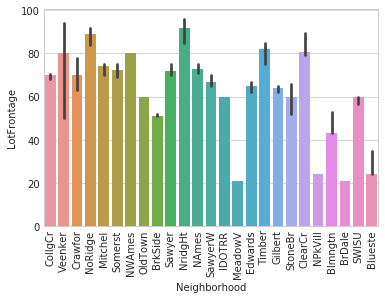

In [15]:
# LotFrontage (conditional filling)

sns.barplot(data=total_df, x='Neighborhood', y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

In [16]:
lotf_median = total_df.groupby('Neighborhood', as_index=False)['LotFrontage'].median()
lotf_median_dict = {k: v for k,v in lotf_median.values}
na_entries = total_df[total_df['LotFrontage'].isnull()].index
for idx in na_entries:
    key = total_df.iloc[idx]['Neighborhood']
    value = lotf_median_dict[key]
    total_df.set_value(idx, 'LotFrontage', value)

### (3) Check no missing values now

In [17]:
total_df[get_missing_cols(total_df)].isnull().sum()

SalePrice    1459
Utilities       2
dtype: int64

- SalePrice missing in test dataset is expected
- Utilities feature would be dropped due to no differentiation (one value extremely dominates) 

# Feature Engineering

### (1) Transform Mis-Typed Numerical to Categorical features

In [18]:
# MSSubClass, YrSold, MoSold are actually categorical, rather than numberical features
total_df['MSSubClass'] = total_df['MSSubClass'].astype(str)
total_df['YrSold'] = total_df['YrSold'].astype(str)
total_df['MoSold'] = total_df['MoSold'].astype(str)

#num_features = [f for f in num_features if f not in ['Id', 'MSSubClass', 'YrSold', 'MoSold']]

### (2) Add combinations of Numerical features  

In [19]:
# Area related features
# inspect data: 1stFlrSF + 2ndFlrSF == GrLivArea

total_df['TotalBath'] = total_df["BsmtFullBath"] + (0.5 * total_df["BsmtHalfBath"]) + total_df["FullBath"] + (0.5 * total_df["HalfBath"])
total_df['AllSF'] = total_df['GrLivArea'] + total_df['TotalBsmtSF']
total_df['AllPorchSF'] = total_df['OpenPorchSF'] + total_df['EnclosedPorch'] + total_df['3SsnPorch'] + total_df['ScreenPorch']

#num_features.extend(['TotalBath', 'AllSF', 'AllPorchSF'])

### (3) Transform Categorical to Numerical features (with ordering, labelencoder) 

In [20]:
# Ordering parts: Alley, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, ExterCond, ExterQual,
#              Fence, FireplaceQu, Functional, GarageCond, GarageFinish, GarageQual, HeatingQC, KitchenQual,
#              LandSlope, LotShape, PavedDrive, PoolQC, Street, Utilities
quality_dict = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
total_df['BsmtCond'] = total_df['BsmtCond'].map(quality_dict).astype(int)
total_df['BsmtQual'] = total_df['BsmtQual'].map(quality_dict).astype(int)
total_df['ExterCond'] = total_df['ExterCond'].map(quality_dict).astype(int)
total_df['ExterQual'] = total_df['ExterQual'].map(quality_dict).astype(int)
total_df['FireplaceQu'] = total_df['FireplaceQu'].map(quality_dict).astype(int)
total_df['GarageCond'] = total_df['GarageCond'].map(quality_dict).astype(int)
total_df['GarageQual'] = total_df['GarageQual'].map(quality_dict).astype(int)
total_df['HeatingQC'] = total_df['HeatingQC'].map(quality_dict).astype(int)
total_df['KitchenQual'] = total_df['KitchenQual'].map(quality_dict).astype(int)
total_df['PoolQC'] = total_df['PoolQC'].map(quality_dict).astype(int)

total_df['Alley'] = total_df['Alley'].map({'NA':0, 'Grvl':1, 'Pave':2}).astype(int)
total_df['BsmtExposure'] = total_df['BsmtExposure'].map({'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}).astype(int)

bsmt_fin_dict = {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
total_df['BsmtFinType1'] = total_df['BsmtFinType1'].map(bsmt_fin_dict).astype(int)
total_df['BsmtFinType2'] = total_df['BsmtFinType2'].map(bsmt_fin_dict).astype(int)

total_df['CentralAir'] = total_df['CentralAir'].map({'N': 0, 'Y': 1}).astype(int)
total_df['Fence'] = total_df['Fence'].map({'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}).astype(int)
total_df['Functional'] = total_df['Functional'].map(
    {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}).astype(int)
total_df['GarageFinish'] = total_df['GarageFinish'].map({'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}).astype(int)
total_df['LandSlope'] = total_df['LandSlope'].map({'Sev': 0, 'Mod': 1, 'Gtl': 2}).astype(int)
total_df['LotShape'] = total_df['LotShape'].map({'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}).astype(int)
total_df['PavedDrive'] = total_df['PavedDrive'].map({'N': 0, 'P': 1, 'Y': 2}).astype(int)
total_df['Street'] = total_df['Street'].map({'Grvl': 0, 'Pave': 1}).astype(int)

# Drop Utilities as mentioned earlier
total_df.drop(['Utilities'], axis=1, inplace=True)

### (4) Add further combinational features of Numerical features

In [21]:
# Overall quality of the house
total_df["OverallGrade"] = total_df["OverallQual"] * total_df["OverallCond"]
# Overall quality of the garage
total_df["GarageGrade"] = total_df["GarageQual"] * total_df["GarageCond"]
# Overall quality of the exterior
total_df["ExterGrade"] = total_df["ExterQual"] * total_df["ExterCond"]
# Overall kitchen grade
total_df["KitchenGrade"] = total_df["KitchenAbvGr"] * total_df["KitchenQual"]
# Overall fireplace grade
total_df["FireplaceGrade"] = total_df["Fireplaces"] * total_df["FireplaceQu"]
# Overall garage grade
total_df["GarageGrade"] = total_df["GarageArea"] * total_df["GarageQual"]
# Overall pool grade
total_df["PoolGrade"] = total_df["PoolArea"] * total_df["PoolQC"]

#num_features.extend(['OverallGrade', 'GarageGrade', 'ExterGrade', 'KitchenGrade', 'FireplaceGrade', 'GarageGrade', 'PoolGrade'])

In [22]:
num_features =[col for col in total_df.columns if total_df.dtypes[col] != 'object' and col not in ['Id']]
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'Alley',
 'BedroomAbvGr',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'EnclosedPorch',
 'ExterCond',
 'ExterQual',
 'Fence',
 'FireplaceQu',
 'Fireplaces',
 'FullBath',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'HeatingQC',
 'KitchenAbvGr',
 'KitchenQual',
 'LandSlope',
 'LotArea',
 'LotFrontage',
 'LotShape',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PavedDrive',
 'PoolArea',
 'PoolQC',
 'SalePrice',
 'ScreenPorch',
 'Street',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBath',
 'AllSF',
 'AllPorchSF',
 'OverallGrade',
 'GarageGrade',
 'ExterGrade',
 'KitchenGrade',
 'FireplaceGrade',
 'PoolGrade']

### (5) Transform Categorical to Numerical features (without ordering, one-hot encoding)

In [23]:
categorical_cols = [col for col in total_df.columns if total_df.dtypes[col] == 'object']
print(categorical_cols)

# Non-Ordering parts: 
total_df = pd.get_dummies(total_df)

categorical_cols = [col for col in total_df.columns if total_df.dtypes[col] == 'object']
print(categorical_cols)

['BldgType', 'Condition1', 'Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating', 'HouseStyle', 'LandContour', 'LotConfig', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'YrSold']
[]


### (6) Split preprocessed dataframe into training and testing datasets

In [24]:
ntrain = train_df.shape[0]
train_txf_df = total_df.head(ntrain)
test_txf_df = total_df.iloc[ntrain:]
train_txf_target = train_txf_df['SalePrice']
train_txf_df.drop(['SalePrice'], axis=1, inplace=True)
test_txf_df.drop(['SalePrice'], axis=1, inplace=True)

num_features.remove('SalePrice')

print(train_txf_df.shape, test_txf_df.shape, train_txf_target.shape)

(1460, 261) (1459, 261) (1460,)


### (7) Unskew features [unskew train dataset, apply to corresponding features in test dataset]

In [25]:
skewed = abs(train_txf_df[num_features].skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed[skewed.values > 0.75]})
skewed_features = skewness.index

print("There are {} skewed numerical features to transform".format(skewness.shape[0]))

# transform skewed featues with log1p
train_txf_df[skewed_features] = np.log1p(train_txf_df[skewed_features])
test_txf_df[skewed_features] = np.log1p(test_txf_df[skewed_features])

# log1p 'SalePrice'(target variable)
train_txf_target = np.log1p(train_txf_target)

There are 44 skewed numerical features to transform


### (8) Feature Scaling [scaling on train dataset, apply to corresponding features in test dataset]

In [26]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(train_txf_df[num_features])
train_txf_df[num_features] = scaler.transform(train_txf_df[num_features])
test_txf_df[num_features] = scaler.transform(test_txf_df[num_features])


### (8) Remove Outliers [training set only] 

In [27]:
# Check outliers w.r.t. SalePrice 
import statsmodels.api as sm

num_cols = [col for col in train_df.columns if train_df.dtypes[col] != 'object']
X = train_df[num_cols].dropna()
y = X['SalePrice']
X = X.drop(['SalePrice','Id'], axis=1)

model = sm.OLS(y, X)
results = model.fit()
bonf_test = results.outlier_test()['bonf(p)']
bonf_outlier = list(bonf_test[bonf_test<1e-3].index) 
print(bonf_outlier)

[523, 691, 803, 898, 1046, 1182, 1298]


In [28]:
# Remove outliers
train_txf_df.drop(bonf_outlier, inplace=True)
train_txf_target.drop(bonf_outlier, inplace=True)
print(train_txf_df.shape, train_txf_target.shape)


(1453, 261) (1453,)


In [29]:
print(train_txf_df.shape, test_txf_df.shape)

(1453, 261) (1459, 261)


# Model Selection
# TODO: follow my another notebook (focused on hyperparameter tuning). 